# pySED calculates the spectral energy density (SED) for MoS$_2$

This tutorial will show how to use pySED to study the spectral energy density for MoS$_2$ and perform the Lorentz fitting.

In addition, this tutorial will use [GPUMD+NEP](https://gpumd.org/) to get molecular dynamics trajectories + velocities, and then pySED to process them to get SED.

Users may need to familiarize themselves with [GPUMD](https://gpumd.org/) software and [NEP](https://gpumd.org/nep/index.html) machine learning potential.

## Installation
In order to install pySED, it is recommended to refer here to install from the [source code](https://github.com/Tingliangstu/pySED?tab=readme-ov-file#installation-instructions).

With that installed, now let's first import the necessary packages to generate the simulation structure.

## Generate supercell structure for GPUMD simulation

In [3]:
from pySED.structure import generate_data

file_name = 'POSCAR_MoS2'        # Triclinic primitive structure of MoS2 with POSCAR format

supercell = (12, 12, 16)         # The number of supercells in the xyz direction

# Generate a structure class
structure = generate_data.structure_maker(structure_file_name=file_name)

# Generate supercell
structure.replicate_supercell(supercell=supercell)

# Write xyz files for gpumd
structure.write_xyz(filename='model.xyz', pbc="T T T")

# Write basis.in files for further used
structure.write_lattice_basis_file()



********************* Reading From VASP POSCAR structure *********************

************* model.xyz is written successfully ************

************* basis.in is written successfully ************



Now we have generated the GPUMD simulation so we have the [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) file and the base.in file that records the mapping between the protocell and the supercell.

Take a look at the contents of basis.in:

In [6]:
with open('basis.in', 'r') as file:
    for _ in range(9):
        print(file.readline())

Create LAMMPS or GPUMD data for SED method by using LT_Codes

atoms_ids unitcell_index basis_index mass_types

1 1 1  95.960000

2 1 2  95.960000

3 1 3  32.065000

4 1 4  32.065000

5 1 5  32.065000

6 1 6  32.065000

7 2 1  95.960000



There are four columns in the basis. 
The first column is the number ID in the supercell, 
the second column is the index of the number of primitive cells, 
the third column is the number of the corresponding basis atom in the supercell, 
and the fourth column is the corresponding mass of the corresponding basis atom.

## GPUMD run
After [model.xyz](https://gpumd.org/gpumd/input_files/model_xyz.html) is generated, we can use GPUMD to generate the trajectory and velocity required for pySED. Here is a [run.in](https://gpumd.org/gpumd/input_files/run_in.html) template.

For the required [nep.txt](https://gpumd.org/nep/output_files/nep_txt.html#index-0), you can fit it yourself or use what we provide.

When GPUMD is finished running, a [dump.xyz](https://gpumd.org/gpumd/input_parameters/dump_exyz.html#dump-exyz) file is output from which pySED can be run.

## pySED calculations

For now, we need to prepare an `input_SED.in` file.

It is recommended to read the [pySED manual](https://pysed.readthedocs.io/) carefully and then understand the meaning of the parameters. Each parameter is very simple, if you really do not understand can carefully read the comments or email developer.

Now we can run pySED to perform SED calculations. Let's start by importing some of the necessary modules.

In [21]:
# Necessary modules
import sys
import os
from pySED import (My_Parsers,
                   Compressor,
                   construct_BZ,
                   Phonon,
                   FileIO,
                   Plot_SED,
                   Lorentz)

After you give the necessary MD simulation parameters to `input_SED.in`, mainly change the following parameters.

pySED has three modes. 

1. The first is to compute the SED data by setting the parameter `plot_SED = 0` in `input_SED.in`.

2. The second mode is SED drawing and fitting mode. When you finish calculating in the first mode, you can start the second mode by setting `plot_SED = 1`.

3. The third model is the complete fit model. The second mode gives a fit for a Q-point (if you set `qpoint_slice_index= xx`). With this Q-point fit, you can legitimately set the `peak_height` and `peak_prominence` parameters. So that pySED can correctly identify the peaks of SED.

   Setting `lorentz_fit_all_qpoint = 1` at this time can enter the third mode, which fully fits all peaks at all q points and outputs a file containing phonon lifetimes (`TOTAL-LORENTZ-Qpoints.Fre_lifetime`).

### Now let's go into the first mode

In [22]:
### **************** Read the input parameter file and get the control parameters ******************
params = My_Parsers.get_parse_input('input_SED.in')

print('\n******************* You are in the SED-Computing mode ********************')

# print(params.output_hdf5 + ' file already exists, and there is no need to compression !!')
if os.path.exists(params.output_hdf5):
   print('\n*************** ' + params.output_hdf5 + ' file will be used ! ****************')
else:
   Compressor.compress(params)
   print('\n******** Compress the velocity and position data to hdf5 is DONE! ********')


******************* You are in the SED-Computing mode ********************

*************** vel_pos_compress.hdf5 file will be used ! ****************


After this step, we compress `dump.xyz` into the `vel_pos_compresse.hdf5` file. We can reuse it later. Let's continue to compute the SED data.

In [23]:
# ***************************** For implement SED Method *******************************
## Construct BZ
BZ_lattice_info = construct_BZ.BZ_methods(params)

## compute SED
phonons = Phonon.spectral_energy_density(params)
phonons.compute_sed(params, BZ_lattice_info)

### Save the data to output files
FileIO.write_output(phonons, params, BZ_lattice_info)

print('\n********** SED-Computing mode is running done for all Q-points, Now you can run plotting mode **********\n')


****** Using velocity unit of A/fs in GPUMD, the unit for SED is convert to J*s ******

****************** Using 8 cores parallelism for computing SED *****************

**************** Estimated computing memory usage: 1530.76 MB. ***************

**************** Now calculate on averaging blocks 1/5 ... ****************


**************** Now calculate on averaging blocks 2/5 ... ****************


**************** Now calculate on averaging blocks 3/5 ... ****************


**************** Now calculate on averaging blocks 4/5 ... ****************


**************** Now calculate on averaging blocks 5/5 ... ****************


************ Time for SED computing taken: 138.62 seconds. ************

********** SED-Computing mode is running done for all Q-points, Now you can run plotting mode **********



After completing this calculation, you have the SED data in the current folder. Here we have three files: 
`bulk_MoS2.SED`, `bulk_MoS2.Qpt`s, `bulk_MoS2.THz`, which respectively represent the SED data of all q points, the q data of Brillouin zone and the corresponding frequency data.

With this data, people can also draw their own pictures. Drawing scripts are also available in the [pySED toolkit](https://github.com/Tingliangstu/pySED/tree/main/tools).
Let's use pySED's built-in features to draw a picture.

### pySED's drawing mode.




***** You are in the single SED-qpoint plotting mode, plot SED for single Q-point *****



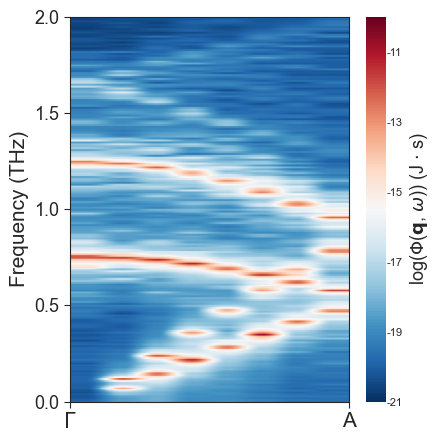

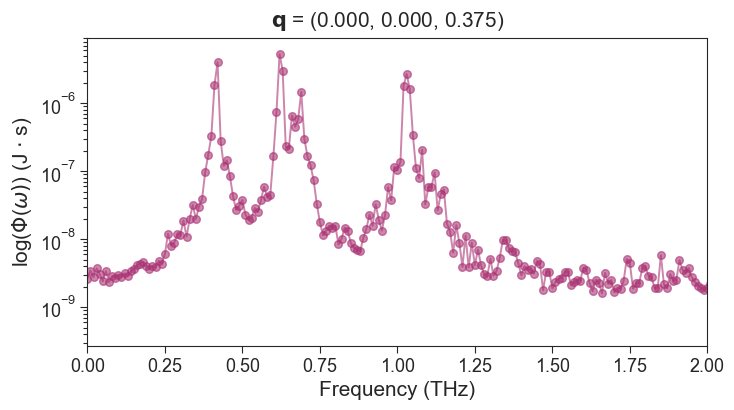

In [25]:
print('\n***** You are in the single SED-qpoint plotting mode, plot SED for single Q-point *****\n')
data = FileIO.load_data(params)
Plot_SED.plot_bands(data, params)
Plot_SED.plot_slice(data, params)

### All fitting mode
We can easily visualize the SED plot with a corresponding q point. From this we can determine `peak_height` and `peak_prominence`. These two represent the highest peak and peak height of the SED peak respectively. see the [scipy usage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) for details.

Here we set `peak_height = 1.0e-6` and `peak_prominence = 1.0e-7`, and then enter the phonon lifetime fit mode.


************************* You are in the ALL plotting mode !!! ************************

***************************************************************************************
***************** Now processing 0-th Qpoint SED Lorentz fitting **********************
****************** WARNING: Now the Frequency will cutoff to 2.000 ********************

*** Found 2 peaks in the SED-0-th qpoint curve, Please compare with the actual peak ***
**** Peaks is as follows, one can tune fitting paras according them ****:
Frequency: [0.75 1.25] THz
Peak_height: [5.76047626e-06 3.05359246e-06] J*s

************** LORENTZ-0-th Qpoints.Fre_lifetime is written successfully **************

**** The fitting hwhm is [0.00917881 0.0056064 ], Please check it. ****
***************************************************************************************
***************** Now processing 1-th Qpoint SED Lorentz fitting **********************
****************** WARNING: Now the Frequency will cutoff to 2.000 **

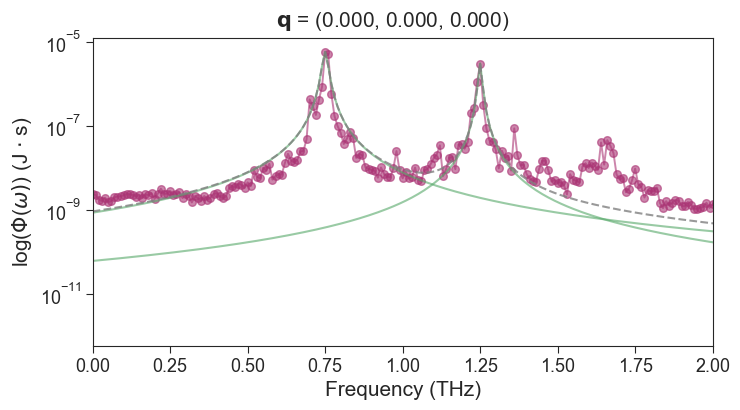

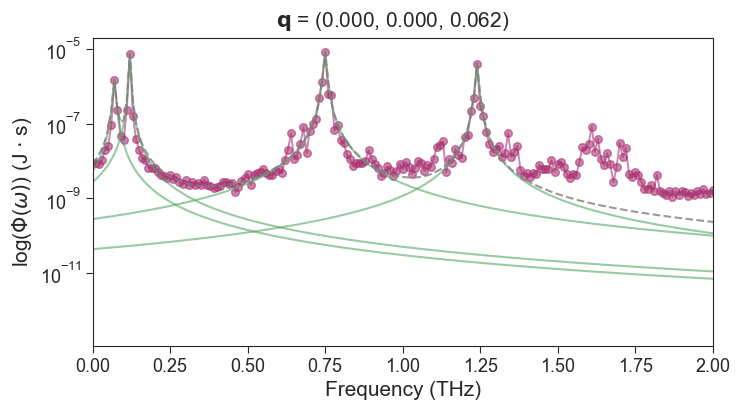

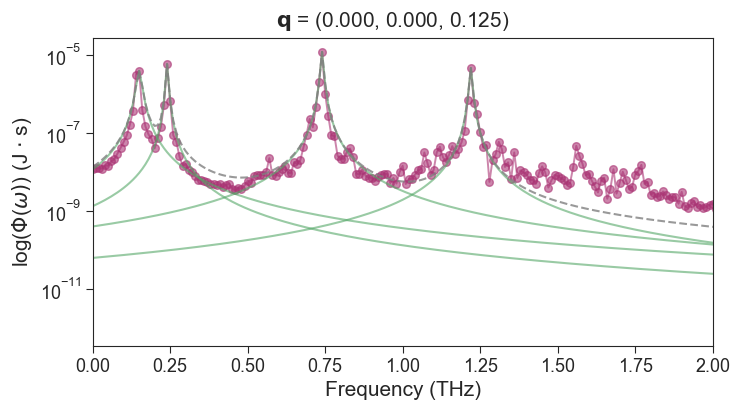

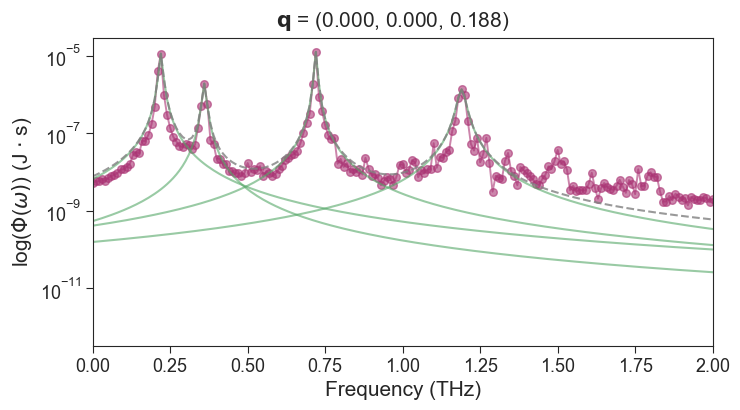

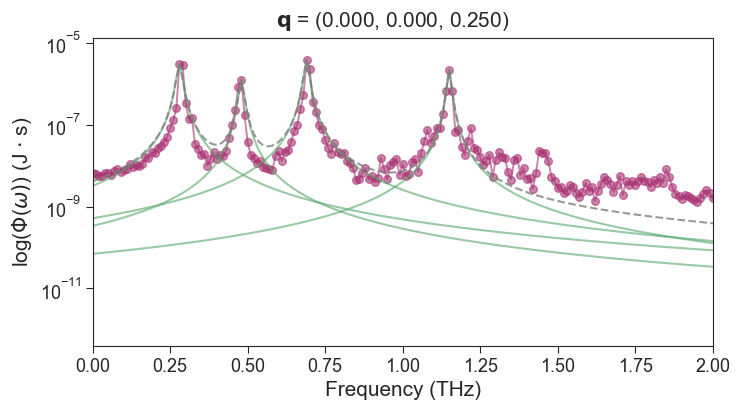

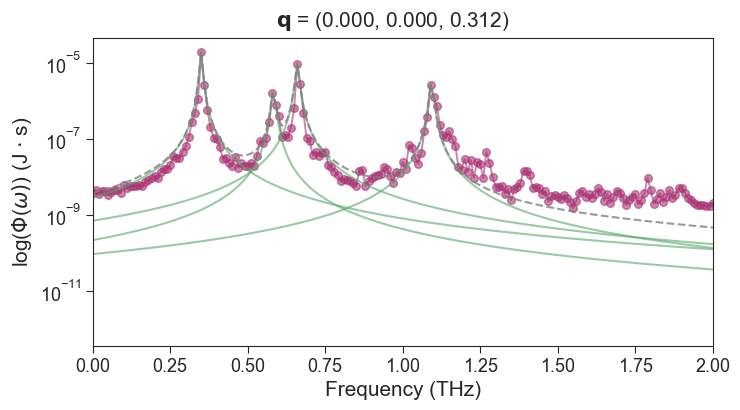

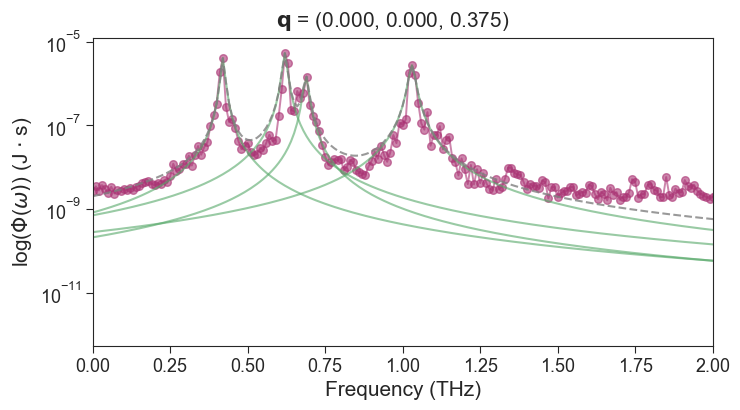

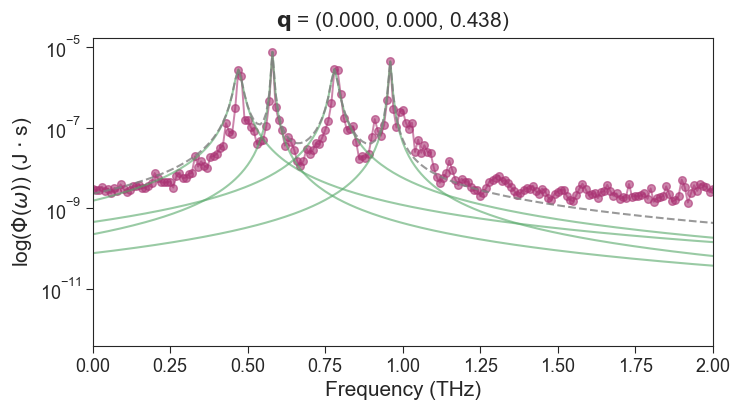

In [29]:
params = My_Parsers.get_parse_input('input_SED.in')    # Here we re-read input_SED.in because it may have been modified

print('\n************************* You are in the ALL plotting mode !!! ************************\n')
for j in range(sum(params.num_qpoints)):
    # Control parameters for all Qpoints
    params.q_slice_index = j
    params.if_show_figures = False
    params.plot_lorentz = False

    print('***************************************************************************************')
    print('***************** Now processing {}-th Qpoint SED Lorentz fitting **********************'.format(j))
    data = FileIO.load_data(params)
    Lorentz.lorentz(data, params)
    
FileIO.deal_total_fre_lifetime(params)
print('\n****************************** pySED PLOTTING ALL DONE !!!!! ****************************')

Through the fitting mode, we can see that pySED finds all the peaks and performs Lorentz fits on them. The fitting results is also OK. The `TOTAL-LORENTZ-Qpoints.Fre_lifetim`e file is output under the current folder, containing the fitted phonon lifetime of all q points. In addition, the fitting of phonon lifetimes at different q points is also output.

We can plot the phonon lifetime.

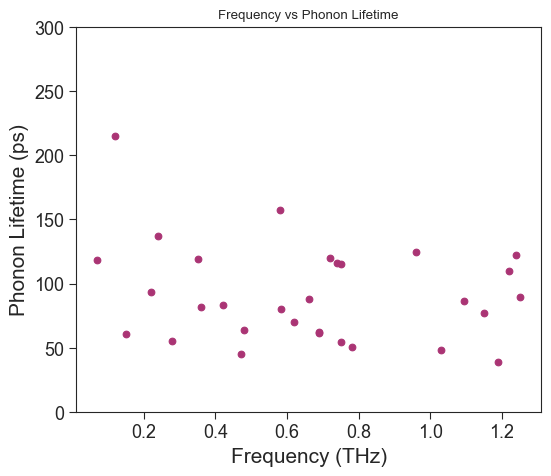

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# *************************** Set Seaborn style for good look *************************
sns.set(style="ticks")
sns.set_context("paper", rc={"axes.linewidth": 0.8, 
                               "xtick.major.width": 0.8, 
                               "ytick.major.width": 0.8,
                               "axes.labelsize": 15, 
                               "xtick.labelsize": 13.0, 
                               "ytick.labelsize": 13.0})
# *************************** Set Seaborn style *************************

data = pd.read_csv('TOTAL-LORENTZ-Qpoints.Fre_lifetime', delim_whitespace=True, comment='#', header=None, skiprows=2)
data.columns = ['Frequency (THz)', 'Phonon Lifetime (ps)']

plt.figure(figsize=(6, 5))
plt.scatter(data['Frequency (THz)'], data['Phonon Lifetime (ps)'], color="#aa3474")
plt.xlabel('Frequency (THz)')
plt.ylabel('Phonon Lifetime (ps)')
plt.ylim([0, 300])
plt.title('Frequency vs Phonon Lifetime')
plt.show()


If you have more q points, this will look better. For q point testing, see the next tutorial.

Through the above tutorial, one can get a general idea of pySED's workflow. SED can be computed easily by calling pySED's classes in python.
Currently, the only inconvenience is the need to call the control file `input_SED.in`. 

pySED also provides a command line to run it.
I hope one can enjoy the process.